In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

sns.set(style="darkgrid")

In [2]:
# dataset G

def get_df_g(ds, fn, roc=False, label=None):
    roc = "ROC" in fn
    res = pd.read_csv(f"./grn_outputs/{ds}/{fn}.csv", index_col=0).T
    if not roc:
        for row in res.index:
            dense = 130 / (100 * 99)
            res.loc[row, :] = res.loc[row, :] / dense
    res = res.reindex(res.mean(axis=0).sort_values(ascending=False).index, axis=1)
    method = []
    value = []

    for col in res.columns:
        col_ = col
        if col == "celloracle":
            col_ = "CellOracle"
        elif col == "scmtni":
            col_ = "scMTNI"
        for idx in res.index:
            if label is None:
                method.append(col_)
            else:
                method.append(f"{col_}_{label}")
            value.append(res.loc[idx, col])
    return pd.DataFrame({ "method": method, "value": value }), res

In [3]:
# dataset M

def get_df_m(ds, fn, roc=False, label=None):
    roc = "ROC" in fn
    res = pd.read_csv(f"./grn_outputs/{ds}/{fn}.csv", index_col=0).T

    if not roc:
        dense = 130 / (100 * 99)
        res = res / dense
    res = res.reindex(res.mean(axis=0).sort_values(ascending=False).index, axis=1)
    method = []
    method_0 = []
    value = []
    ngenes = []
    sigmas = []
    ds = []
    labels = []

    for col in res.columns:
        col_ = col
        if col == "celloracle":
            col_ = "CellOracle"
        elif col == "scmtni":
            col_ = "scMTNI"
        for idx in res.index:
            ngenes.append(int(re.search(r"cells(\d+)_genes", idx)[1]))
            sigmas.append(float(re.search(r"_sigma([\.\d]+)_", idx)[1]))
            method_0.append(col_)
            if label is None:
                method.append(col_)
                labels.append("")
            else:
                method.append(f"{col_}_{label}")
                labels.append(label)
            value.append(res.loc[idx, col])
            ds.append(idx)
    return pd.DataFrame({ "method": method, "value": value, "ngenes": ngenes, "sigma": sigmas, "ds": ds, "label": labels, "method_0": method_0 })

/var/folders/c9/fwxclx5116lgnxc4p5jl_hs40000gn/T/ipykernel_99232/1184754677.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.set_yticklabels(["%0.1f" % i for i in pl.get_yticks()], size = 16)
/var/folders/c9/fwxclx5116lgnxc4p5jl_hs40000gn/T/ipykernel_99232/1184754677.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.set_yticklabels(["%0.1f" % i for i in pl.get_yticks()], size = 16)
/var/folders/c9/fwxclx5116lgnxc4p5jl_hs40000gn/T/ipykernel_99232/1184754677.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.set_yticklabels(["%0.1f" % i for i in pl.get_yticks()], size = 16)
/var/folders/c9/fwxclx5116lgnxc4p5jl_hs40000gn/T/ipykernel_99232/1184754677.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.set_yticklabels(["%0.1f" % i for i in pl.get_yticks()], size = 16)


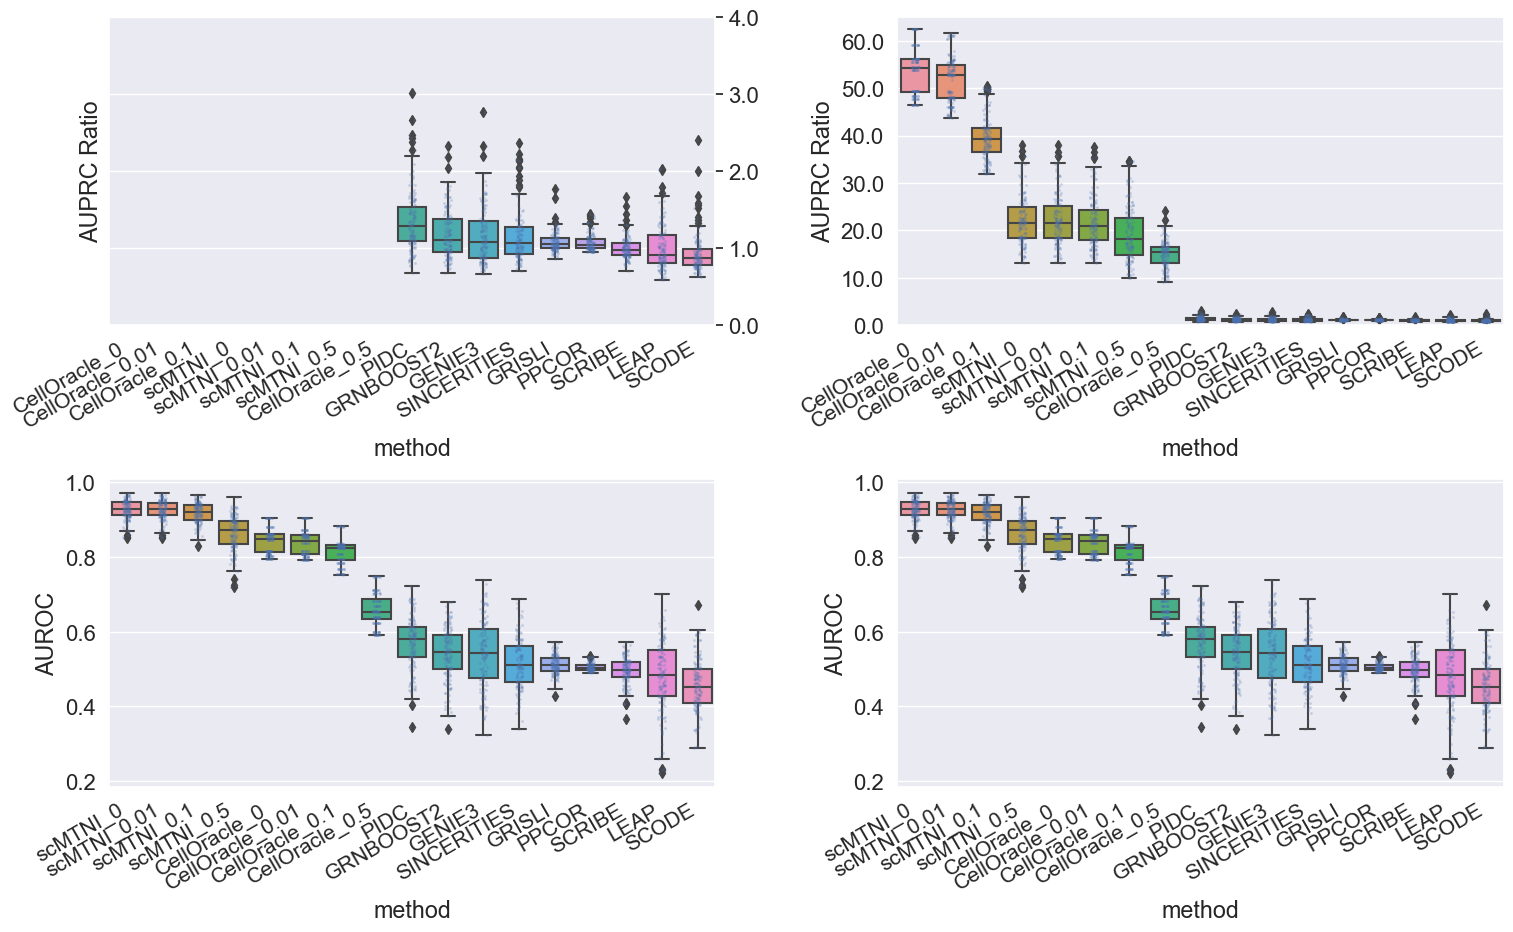

In [5]:
def plot_grn_main():
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
    sns.set(font_scale = 1.4)
    for auc in ["PRC", "ROC"]:
        df_all = None
        is_roc = auc == "ROC"
        for tree in [1, 3, 5]:
            t = "" if tree == 1 else str(tree)
            a_0_500 = get_df_m("unif", f"unif{t}_0-AU{auc}", roc=is_roc)
            a_1_500 = get_df_m("unif", f"unif{t}_1-AU{auc}", roc=is_roc)
            a_0_800 = get_df_m("unif", f"unif{t}_0_800-AU{auc}", roc=is_roc)
            a_1_800 = get_df_m("unif", f"unif{t}_1_800-AU{auc}", roc=is_roc)
            df = pd.concat((a_0_500, a_1_500, a_0_800, a_1_800))
            df["tree"] = tree
            if df_all is None:
                df_all = df
            else:
                df_all = pd.concat((df_all, df))
        # new_2 = get_df_m("unif", f"new-AU{auc}", roc=is_roc)
        for nl in ["0", "0.01", "0.1", "0.5"]:
            new_2 = get_df_m("unif", f"unif_noise_level_{nl}-AU{auc}", roc=is_roc, label=nl)
            df_all = pd.concat((df_all, new_2))
        
        df_all.index = range(len(df_all))
        df = df_all
        df = df[df.method != "GRNVBEM"]
        df = df[df.method != "SINGE"]
        # return(df.groupby("ds").mean().sort_values(by="value"))
        order = df.groupby("method").value.mean().sort_values(ascending=False).index
        # for i, ngenes in [(0, 110), (1, 200), (2, 500)]:
            # pl = sns.boxplot(df[df.ngenes == ngenes], y="value", x="method", ax=axs[1 if is_roc else 0, i])
        # for i, tree in [(0, 1), (1, 3), (2, 5)]:
        #     pl = sns.boxplot(df[df.tree == tree], y="value", x="method", ax=axs[1 if is_roc else 0, i])
        
        pl = sns.boxplot(df_all, y="value", x="method", order=order, ax=axs[1 if is_roc else 0, 0])
        sns.stripplot(df_all, y="value", x="method", order=order, ax=pl, alpha=.25, dodge=True, size=2)
        pl.set(ylabel=("AUROC" if is_roc else "AUPRC Ratio"))
        if not is_roc:
            pl.set(ylim=(0, 4))
        pl.set_xticklabels(pl.get_xticklabels(),rotation = 30, horizontalalignment='right')
        pl.set_yticklabels(["%0.1f" % i for i in pl.get_yticks()], size = 16)

        pl = sns.boxplot(df_all, y="value", x="method", order=order, ax=axs[1 if is_roc else 0, 1])
        sns.stripplot(df_all, y="value", x="method", order=order, ax=pl, alpha=.25, dodge=True, size=2)
        pl.set(ylabel=("AUROC" if is_roc else "AUPRC Ratio"))
        if not is_roc:
            pl.set(ylim=(0, 65))
        pl.set_xticklabels(pl.get_xticklabels(),rotation = 30, horizontalalignment='right')
        pl.set_yticklabels(["%0.1f" % i for i in pl.get_yticks()], size = 16)
        
    axs[0, 0].yaxis.tick_right()
    plt.savefig(f"unif_grn.pdf")
            
plot_grn_main()

/var/folders/c9/fwxclx5116lgnxc4p5jl_hs40000gn/T/ipykernel_54718/542004831.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_yticklabels(["%0.1f" % i for i in a.get_yticks()], size = 16)
/var/folders/c9/fwxclx5116lgnxc4p5jl_hs40000gn/T/ipykernel_54718/542004831.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_yticklabels(["%0.1f" % i for i in a.get_yticks()], size = 16)
/var/folders/c9/fwxclx5116lgnxc4p5jl_hs40000gn/T/ipykernel_54718/542004831.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_yticklabels(["%0.1f" % i for i in a.get_yticks()], size = 16)
/var/folders/c9/fwxclx5116lgnxc4p5jl_hs40000gn/T/ipykernel_54718/542004831.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_yticklabels(["%0.1f" % i for i in a.get_yticks()], size = 16)
/var/folders/c9/fwxclx5116lgnxc4p5jl_hs40000gn/T/ipykernel_54718/542004831.py:68: UserWarnin

scm2.pdf


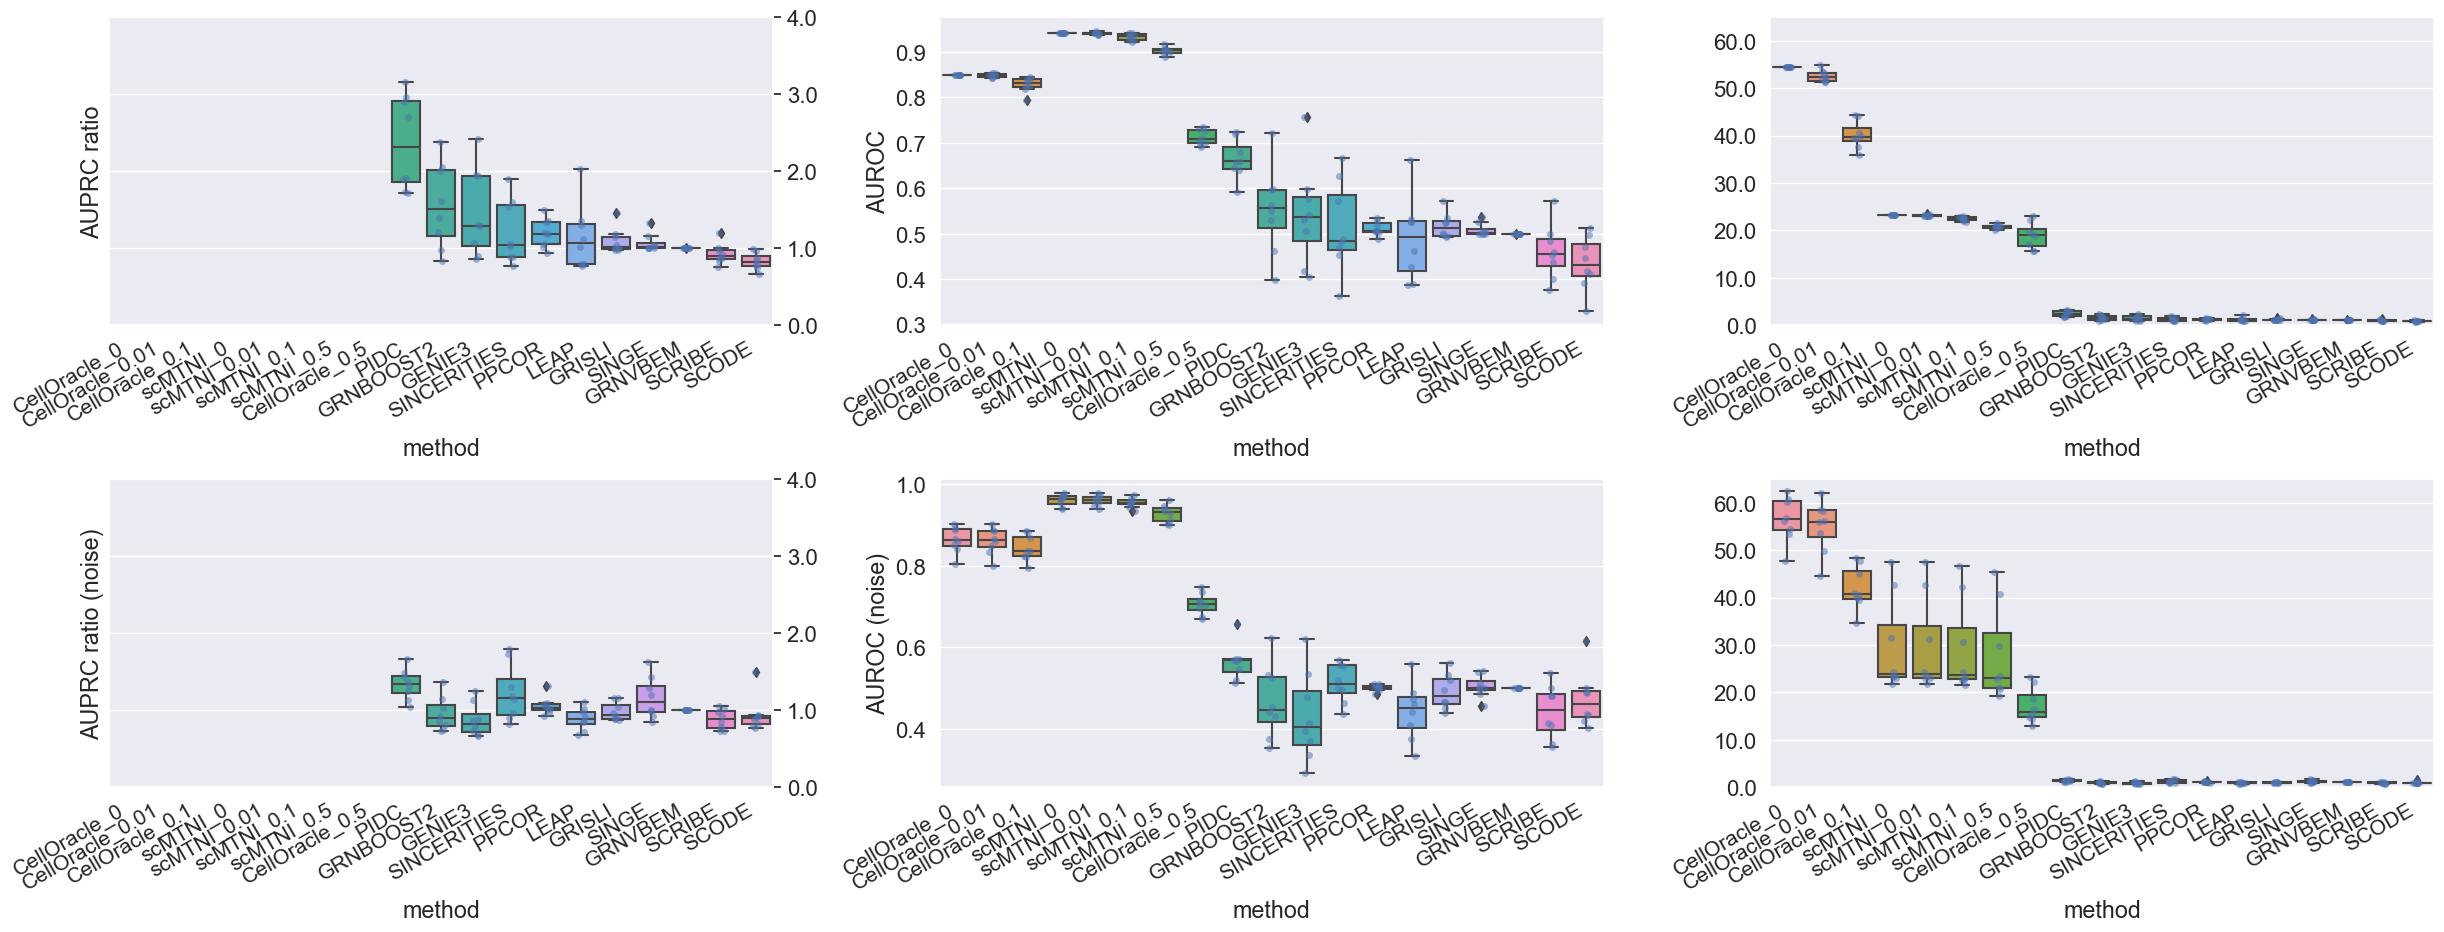

In [5]:
def plot_grn_aux(ds):
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30, 10))
    plt.subplots_adjust(hspace=0.5, wspace=0.25)
    
    sns.set(font_scale = 1.4)
    
    x, res = get_df_g(ds, "AUPRC_nonoise")
    x = pd.concat([
        x,
        get_df_g("G1", "G1_noise_level_0-AUPRC", label="0")[0],
        get_df_g("G1", "G1_noise_level_0.01-AUPRC", label="0.01")[0],
        get_df_g("G1", "G1_noise_level_0.1-AUPRC", label="0.1")[0],
        get_df_g("G1", "G1_noise_level_0.5-AUPRC", label="0.5")[0]
    ])
    order = x.groupby("method").value.mean().sort_values(ascending=False).index

    a = sns.boxplot(x, y="value", x="method", order=order, ax=axs[0, 0])
    sns.stripplot(x, y="value", x="method", order=order, ax=a, alpha=.5, dodge=True)
    axs[0, 0].yaxis.tick_right()
    a.set(ylabel='AUPRC ratio')
    a.set(ylim=(0, 4))
    a.set_xticklabels(a.get_xticklabels(),rotation = 30, horizontalalignment='right')
    a.set_yticklabels(["%0.1f" % i for i in a.get_yticks()], size = 16)

    a = sns.boxplot(x, y="value", x="method", order=order, ax=axs[0, 2])
    sns.stripplot(x, y="value", x="method", order=order, ax=a, alpha=.5, dodge=True)
    a.set(ylabel='')
    a.set(ylim=(0, 65))
    a.set_xticklabels(a.get_xticklabels(),rotation = 30, horizontalalignment='right')
    a.set_yticklabels(["%0.1f" % i for i in a.get_yticks()], size = 16)
    
    x, _ = get_df_g(ds, "GSD-AUPRC")
    x = pd.concat([
        x,
        get_df_g("G2", "G2_noise_level_0-AUPRC", label="0")[0],
        get_df_g("G2", "G2_noise_level_0.01-AUPRC", label="0.01")[0],
        get_df_g("G2", "G2_noise_level_0.1-AUPRC", label="0.1")[0],
        get_df_g("G2", "G2_noise_level_0.5-AUPRC", label="0.5")[0]
    ])

    a = sns.boxplot(x, y="value", x="method", order=order, ax=axs[1, 0])
    sns.stripplot(x, y="value", x="method", order=order, ax=a, alpha=.5, dodge=True)
    axs[1, 0].yaxis.tick_right()
    a.set(ylabel='AUPRC ratio (noise)')
    a.set(ylim=(0, 4))
    a.set_xticklabels(a.get_xticklabels(),rotation = 30, horizontalalignment='right')
    a.set_yticklabels(["%0.1f" % i for i in a.get_yticks()], size = 16)

    a = sns.boxplot(x, y="value", x="method", order=order, ax=axs[1, 2])
    sns.stripplot(x, y="value", x="method", order=order, ax=a, alpha=.5, dodge=True)
    a.set(ylabel='')
    a.set(ylim=(0, 65))
    a.set_xticklabels(a.get_xticklabels(),rotation = 30, horizontalalignment='right')
    a.set_yticklabels(["%0.1f" % i for i in a.get_yticks()], size = 16)
    
    x, _ = get_df_g(ds, "AUROC_nonoise", roc=True)
    x = pd.concat([
        x,
        get_df_g("G1", "G1_noise_level_0-AUROC", label="0", roc=True)[0],
        get_df_g("G1", "G1_noise_level_0.01-AUROC", label="0.01", roc=True)[0],
        get_df_g("G1", "G1_noise_level_0.1-AUROC", label="0.1", roc=True)[0],
        get_df_g("G1", "G1_noise_level_0.5-AUROC", label="0.5", roc=True)[0]
    ])
    a = sns.boxplot(x, y="value", x="method", order=order, ax=axs[0, 1])
    sns.stripplot(x, y="value", x="method", order=order, ax=a, alpha=.5, dodge=True)
    a.set(ylabel='AUROC')
    a.set_xticklabels(a.get_xticklabels(),rotation = 30, horizontalalignment='right')
    a.set_yticklabels(["%0.1f" % i for i in a.get_yticks()], size = 16)
    
    x, _ = get_df_g(ds, "GSD-AUROC", roc=True)
    x = pd.concat([
        x,
        get_df_g("G2", "G2_noise_level_0-AUROC", label="0", roc=True)[0],
        get_df_g("G2", "G2_noise_level_0.01-AUROC", label="0.01", roc=True)[0],
        get_df_g("G2", "G2_noise_level_0.1-AUROC", label="0.1", roc=True)[0],
        get_df_g("G2", "G2_noise_level_0.5-AUROC", label="0.5", roc=True)[0]
    ])
    a = sns.boxplot(x, y="value", x="method", order=order, ax=axs[1, 1])
    sns.stripplot(x, y="value", x="method", order=order, ax=a, alpha=.5, dodge=True)
    a.set(ylabel='AUROC (noise)')
    a.set_xticklabels(a.get_xticklabels(),rotation = 30, horizontalalignment='right')
    a.set_yticklabels(["%0.1f" % i for i in a.get_yticks()], size = 16)
    
    print(f"{ds}.pdf")
    plt.savefig(f"{ds}.pdf")

plot_grn_aux("scm2")

/opt/homebrew/Caskroom/miniconda/base/envs/diff/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/diff/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


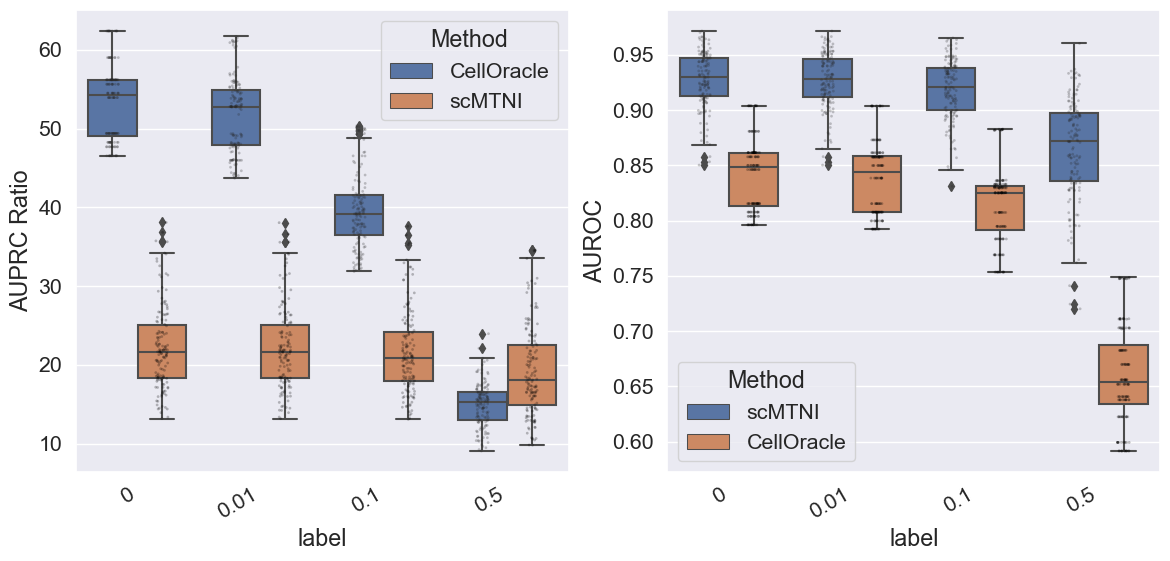

In [14]:
def plot_grn_supp():
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    
    for auc in ["PRC", "ROC"]:
        df_all = None
        is_roc = auc == "ROC"
        for nl in ["0", "0.01", "0.1", "0.5"]:
            df = get_df_m("unif", f"unif_noise_level_{nl}-AU{auc}", roc=is_roc, label=nl)
            if df_all is None:
                df_all = df
            else:
                df_all = pd.concat((df_all, df))
        
        df = df_all
        order = df.groupby("label").value.mean().sort_values(ascending=False).index
        
        pl = sns.boxplot(df_all, y="value", x="label", hue="method_0", order=order, ax=axs[1 if is_roc else 0])
        sns.stripplot(df_all, y="value", x="label", hue="method_0", color="black", order=order, ax=pl, alpha=.25, dodge=True, size=2, legend=False)
        pl.set(ylabel=("AUROC" if is_roc else "AUPRC Ratio"))
        pl.set_xticklabels(pl.get_xticklabels(),rotation = 30, horizontalalignment='right')

    axs[0].legend(title="Method")
    axs[1].legend(title="Method")
        
    plt.savefig(f"unif_grn_supp.pdf")
            
plot_grn_supp()